# Extracting, analyzing and visualizing spatial entities from Tripadvisor text data

## Libraries and Settings

In [1]:
# Libraries
import os
import sys
import spacy
import requests
import folium
from folium import Popup
import pandas as pd
from tqdm import tqdm
from wordcloud import WordCloud
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import clear_output

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")

print(os.getcwd())

/workspaces/spatial_data_analysis/07_Python_Tripadvisor


## Import data about day trips in Switzerland

Note that the data were collected using the Chrome Web Scraper extension (see file 'webscraper_tripadvisor.json')

In [2]:
# Data from Tripadvisor derived via web scraping
df = pd.read_csv('tripadvisor.csv')

# Get the shape of the dataframe
print(df.shape)

df.head(10)

(282, 7)


,web-scraper-order,web-scraper-start-url,title_raw,price_raw,ranking_raw,duration_raw,text_raw
0,1713267369-1,https://www.tripadvisor.ch/Attraction_Products...,31. Titlis-Tagesausflug mit privatem Reiseleit...,CHF 496,5.0 von fünf Punkten1,6 - 8 Stunden,31. Titlis-Tagesausflug mit privatem Reiseleit...
1,1713267369-2,https://www.tripadvisor.ch/Attraction_Products...,32. Alpine Majestät: Exklusive Privattour von ...,CHF 699,NaN,Mehr als 6 Stunden,32. Alpine Majestät: Exklusive Privattour von ...
2,1713267369-3,https://www.tripadvisor.ch/Attraction_Products...,33. Privattour zu den atemberaubendsten Inside...,CHF 1’999,5.0 von fünf Punkten47,Mehr als 6 Stunden,33. Privattour zu den atemberaubendsten Inside...
3,1713267369-4,https://www.tripadvisor.ch/Attraction_Products...,34. Vierwaldstättersee Pick and Mix Tour - Bur...,CHF 689,5.0 von fünf Punkten34,8 - 9 Stunden,34. Vierwaldstättersee Pick and Mix Tour - Bur...
4,1713267369-5,https://www.tripadvisor.ch/Attraction_Products...,35. Atemberaubende private Wanderung mit einem...,CHF 899,5.0 von fünf Punkten26,8 - 9 Stunden,35. Atemberaubende private Wanderung mit einem...
5,1713267369-6,https://www.tripadvisor.ch/Attraction_Products...,36. Best of Bernese Oberland Tour ab Interlaken,CHF 721,5.0 von fünf Punkten12,Mehr als 6 Stunden,36. Best of Bernese Oberland Tour ab Interlake...
6,1713267369-7,https://www.tripadvisor.ch/Attraction_Products...,37. Die Naturwunder der Schweiz: Privattour ab...,CHF 959,5.0 von fünf Punkten11,Mehr als 6 Stunden,37. Die Naturwunder der Schweiz: Privattour ab...
7,1713267369-8,https://www.tripadvisor.ch/Attraction_Products...,38. Ganztägige Wanderung durch die Schweizer A...,CHF 148,5.0 von fünf Punkten9,8 - 11 Stunden,38. Ganztägige Wanderung durch die Schweizer A...
8,1713267369-9,https://www.tripadvisor.ch/Attraction_Products...,39. Best of Berner Oberland & Schweizer Landsc...,CHF 680,5.0 von fünf Punkten8,Mehr als 6 Stunden,39. Best of Berner Oberland & Schweizer Landsc...
9,1713267369-10,https://www.tripadvisor.ch/Attraction_Products...,40. Bruchlandung auf Ihrer privaten Tagestour ...,CHF 965,5.0 von fünf Punkten8,8 - 9 Stunden,40. Bruchlandung auf Ihrer privaten Tagestour ...


## Extract locations by using Named Entity Recognition (NER)

### Show locations in titles

In [3]:
# All titles
print(df['title_raw'])

# Single title
print('\n', df.loc[df['web-scraper-order'] == '1713267369-7']['title_raw'].values[0])

0      31. Titlis-Tagesausflug mit privatem Reiseleit...
1      32. Alpine Majestät: Exklusive Privattour von ...
2      33. Privattour zu den atemberaubendsten Inside...
3      34. Vierwaldstättersee Pick and Mix Tour - Bur...
4      35. Atemberaubende private Wanderung mit einem...
                             ...                        
277    248. Lugano und Morcote, private Führung ab Ma...
278      249. VIP-Erlebnis zum Comer See und nach Lugano
279    250. Jungfraujoch Top of Europe und Region Pri...
280    251.  Ganztägiger Privatausflug von Zürich nac...
281    252. Ab Zürich: Private Schneewanderung, Berg-...
Name: title_raw, Length: 282, dtype: object

 37. Die Naturwunder der Schweiz: Privattour ab Luzern (1 Tag)


## Plot wordcloud from 'title_raw'

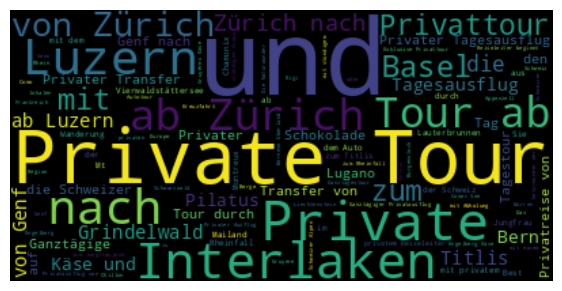

In [4]:
# Join all reviews into a single string and create a WordCloud object
text = ' '.join(review for review in df['title_raw'])

# Create and generate a word cloud image:
wordcloud = WordCloud(background_color="black").generate(text)

# Display the generated image:
plt.figure(figsize=(7, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

### Named Entity Recognition (NER) example

Note that, when you use a language model in SpaCy, like "en_core_web_sm", it processes the text to perform various Natural Language Processing (NLP) tasks. These tasks typically include tokenization, part-of-speech tagging, dependency parsing, lemmatization, and named entity recognition (NER).

For details see: https://spacy.io/api

In [5]:
# Load the German language model
nlp = spacy.load("de_core_news_sm")

# Example texts with their identifiers
df_example = pd.DataFrame({
                    'id': ['1', '2', '3'],
                    'title_raw': ['Titlis-Tagesausflug mit privatem Reiseleiter ab Zürich.', 
                                  'VIP-Erlebnis zum Comer See und nach Lugano.',
                                  'Private Schneewanderung im Ab Berner Oberland.']})

texts = df_example['title_raw']

# Loop through the texts and extract the entities
for text in texts:
    doc = nlp(text)
    for ent in doc.ents:
        print(ent.text, '|', ent.label_)


Zürich | LOC
Comer See | LOC
Lugano | LOC
Private Schneewanderung | ORG
Berner Oberland | LOC


### Extract locations from Tripadvisor data

In [6]:
# Load the German language model
nlp = spacy.load("de_core_news_sm")

# Example texts with their identifiers
texts = df[['web-scraper-order', 'title_raw']]

# Function to extract locations, their labels, and web-scraper-order from original data
def extract_locations(texts):
    locations = []
    for idx, row in texts.iterrows():
        doc = nlp(row['title_raw'])
        for ent in doc.ents:
            if ent.label_ == "LOC" or ent.label_ == "GPE":
                locations.append((row['web-scraper-order'], ent.text, ent.label_))
    return locations

# Extract locations
locations_with_labels_ids = extract_locations(texts)

# Create a DataFrame with location names, their labels, and the IDs
df_locations = pd.DataFrame(locations_with_labels_ids, columns=['web-scraper-order', 'location', 'entity_type'])

# Remove duplicate locations
df_locations_unique = df_locations.drop_duplicates().reset_index(drop=True)

# Filter out location names longer than 25 characters
df_locations_filtered = df_locations_unique[df_locations_unique['location'].apply(len) <= 25]

# Display the DataFrame
print(df_locations_filtered)

    web-scraper-order      location entity_type
0        1713267369-1        Luzern         LOC
1        1713267369-2  Jungfraujoch         LOC
2        1713267369-3       Schweiz         LOC
3        1713267369-4        Luzern         LOC
4        1713267369-6    Interlaken         LOC
..                ...           ...         ...
485    1713267369-280        Zürich         LOC
486    1713267369-281        Zürich         LOC
487    1713267369-281    Interlaken         LOC
488    1713267369-281   Grindelwald         LOC
489    1713267369-282        Zürich         LOC

[485 rows x 3 columns]


## Geocode locations

In [7]:
# Define the base URL for the GeoAdmin API
base_url = "https://api3.geo.admin.ch/rest/services/api/SearchServer?"

# Initialize a list to store IDs, coordinates, or NA along with location names
coordinates_list = []

# Loop through each address and ID in the DataFrame (with progress bar)
for idx, row in tqdm(df_locations_filtered.iterrows(),
                     total = df_locations_filtered.shape[0], 
                     bar_format='{l_bar}{bar}'):
    
    # Set up search parameters for each location
    parameters = {
        "searchText": row['location'],
        "origins": "address",
        "type": "locations"
    }

    # Send the request to the GeoAdmin API
    response = requests.get(base_url, params=parameters)

    # Check the response status and process the data
    if response.status_code == 200:
        data = response.json()
        if data['results']:
            first_result = data['results'][0]['attrs']
            lat = first_result.get('lat', None)
            lon = first_result.get('lon', None)
            coordinates_list.append([row['web-scraper-order'], 
                                     row['location'], lat, lon])
        else:
            coordinates_list.append([row['web-scraper-order'], 
                                     row['location'], None, None])
    else:
        coordinates_list.append([row['web-scraper-order'], 
                                 row['location'], None, None])
        
# Convert the list to a DataFrame with specified column names
df_geocoded = pd.DataFrame(coordinates_list, columns=['web-scraper-order', 
                                                      'location', 
                                                      'latitude', 
                                                      'longitude'])

# Display the DataFrame
df_geocoded


100%|██████████


,web-scraper-order,location,latitude,longitude
0,1713267369-1,Luzern,47.052547,8.282178
1,1713267369-2,Jungfraujoch,46.546886,7.983592
2,1713267369-3,Schweiz,47.494625,9.214692
3,1713267369-4,Luzern,47.052547,8.282178
4,1713267369-6,Interlaken,46.678734,7.870780
...,...,...,...,...
480,1713267369-280,Zürich,47.141186,7.629510
481,1713267369-281,Zürich,47.141186,7.629510
482,1713267369-281,Interlaken,46.678734,7.870780
483,1713267369-281,Grindelwald,47.032753,8.096479


## Merge the original DataFrame with the geocoded DataFrame

In [8]:
# Merge the original DataFrame with the geocoded DataFrame
merged_df_orig = pd.merge(df[['web-scraper-order', 
                              'title_raw', 
                              'price_raw', 
                              'ranking_raw', 
                              'duration_raw',
                              'text_raw']], df_geocoded, 
                              on='web-scraper-order', 
                              how='left')
merged_df_orig

,web-scraper-order,title_raw,price_raw,ranking_raw,duration_raw,text_raw,location,latitude,longitude
0,1713267369-1,31. Titlis-Tagesausflug mit privatem Reiseleit...,CHF 496,5.0 von fünf Punkten1,6 - 8 Stunden,31. Titlis-Tagesausflug mit privatem Reiseleit...,Luzern,47.052547,8.282178
1,1713267369-2,32. Alpine Majestät: Exklusive Privattour von ...,CHF 699,NaN,Mehr als 6 Stunden,32. Alpine Majestät: Exklusive Privattour von ...,Jungfraujoch,46.546886,7.983592
2,1713267369-3,33. Privattour zu den atemberaubendsten Inside...,CHF 1’999,5.0 von fünf Punkten47,Mehr als 6 Stunden,33. Privattour zu den atemberaubendsten Inside...,Schweiz,47.494625,9.214692
3,1713267369-4,34. Vierwaldstättersee Pick and Mix Tour - Bur...,CHF 689,5.0 von fünf Punkten34,8 - 9 Stunden,34. Vierwaldstättersee Pick and Mix Tour - Bur...,Luzern,47.052547,8.282178
4,1713267369-5,35. Atemberaubende private Wanderung mit einem...,CHF 899,5.0 von fünf Punkten26,8 - 9 Stunden,35. Atemberaubende private Wanderung mit einem...,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...
511,1713267369-280,250. Jungfraujoch Top of Europe und Region Pri...,CHF 1’046,NaN,Mehr als 6 Stunden,250. Jungfraujoch Top of Europe und Region Pri...,Zürich,47.141186,7.629510
512,1713267369-281,251. Ganztägiger Privatausflug von Zürich nac...,CHF 1’688,NaN,Mehr als 6 Stunden,251. Ganztägiger Privatausflug von Zürich nac...,Zürich,47.141186,7.629510
513,1713267369-281,251. Ganztägiger Privatausflug von Zürich nac...,CHF 1’688,NaN,Mehr als 6 Stunden,251. Ganztägiger Privatausflug von Zürich nac...,Interlaken,46.678734,7.870780
514,1713267369-281,251. Ganztägiger Privatausflug von Zürich nac...,CHF 1’688,NaN,Mehr als 6 Stunden,251. Ganztägiger Privatausflug von Zürich nac...,Grindelwald,47.032753,8.096479


# Filter day trips with price information 'per adult'

In [9]:
# Check price 'per adult'
merged_df_orig['price_per_adult'] = merged_df_orig['text_raw'].str.contains('pro Erwachsenem').astype(int)

# Filter only prices with information 'per adult'
merged_df = merged_df_orig[merged_df_orig['price_per_adult'] == 1].reset_index(drop=True)

# Show remaining number of rows
print(merged_df.shape)

# Display the DataFrame
merged_df.head()

(412, 10)


,web-scraper-order,title_raw,price_raw,ranking_raw,duration_raw,text_raw,location,latitude,longitude,price_per_adult
0,1713267369-1,31. Titlis-Tagesausflug mit privatem Reiseleit...,CHF 496,5.0 von fünf Punkten1,6 - 8 Stunden,31. Titlis-Tagesausflug mit privatem Reiseleit...,Luzern,47.052547,8.282178,1
1,1713267369-2,32. Alpine Majestät: Exklusive Privattour von ...,CHF 699,NaN,Mehr als 6 Stunden,32. Alpine Majestät: Exklusive Privattour von ...,Jungfraujoch,46.546886,7.983592,1
2,1713267369-4,34. Vierwaldstättersee Pick and Mix Tour - Bur...,CHF 689,5.0 von fünf Punkten34,8 - 9 Stunden,34. Vierwaldstättersee Pick and Mix Tour - Bur...,Luzern,47.052547,8.282178,1
3,1713267369-5,35. Atemberaubende private Wanderung mit einem...,CHF 899,5.0 von fünf Punkten26,8 - 9 Stunden,35. Atemberaubende private Wanderung mit einem...,NaN,NaN,NaN,1
4,1713267369-6,36. Best of Bernese Oberland Tour ab Interlaken,CHF 721,5.0 von fünf Punkten12,Mehr als 6 Stunden,36. Best of Bernese Oberland Tour ab Interlake...,Interlaken,46.678734,7.870780,1


## Analyze prices of day trips

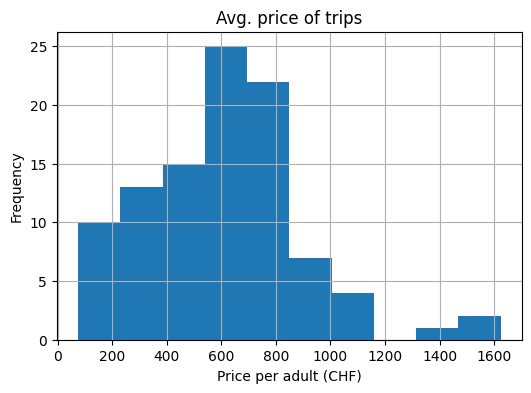

,web-scraper-order,title_raw,price,location,duration_raw,ranking_raw
215,1713267369-174,144. Ganztägige private Tour von Zürich nach J...,1958,Zürich,Mehr als 6 Stunden,NaN
216,1713267369-174,144. Ganztägige private Tour von Zürich nach J...,1958,Jungfrau,Mehr als 6 Stunden,NaN
217,1713267369-174,144. Ganztägige private Tour von Zürich nach J...,1958,Interlaken,Mehr als 6 Stunden,NaN
357,1713267369-250,220. Ganztägiger Privatausflug von Genf zum Ti...,1937,Titlis,Mehr als 6 Stunden,NaN
358,1713267369-250,220. Ganztägiger Privatausflug von Genf zum Ti...,1937,Luzern,Mehr als 6 Stunden,NaN


In [10]:
# Extract numbers from the string
merged_df['price'] = merged_df['price_raw'].str.strip()
merged_df['price'] = merged_df['price'].str.extract(r'(\d+’?\d*)')
merged_df['price'] = merged_df['price'].str.replace("’", "").astype(int)

# Pivot table to get the average price for each location
pivot_table = merged_df.pivot_table(index='location', 
                                    values='price', 
                                    aggfunc='mean').reset_index()

pivot_table.sort_values(by='price', ascending=False)

# Histogram with average price of trips
plt.figure(figsize=(6, 4))
plt.hist(pivot_table['price'])
plt.title('Avg. price of trips')
plt.xlabel('Price per adult (CHF)')
plt.ylabel('Frequency')
plt.grid()
plt.show()

# Filter most expensive trips
most_expensive_trips = merged_df[merged_df['price'] >= 1500].sort_values(by='price', ascending=False)
most_expensive_trips[['web-scraper-order', 'title_raw', 'price', 'location', 'duration_raw', 'ranking_raw']].head()

## Analyze duration of day trips


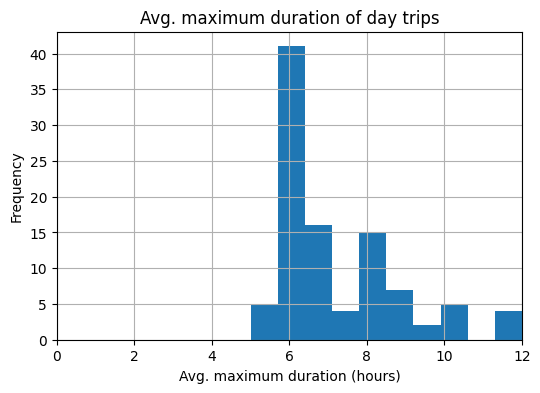

In [11]:
# Extract numbers from the string
merged_df['max_duration'] = merged_df['duration_raw'].str.strip()
merged_df['max_duration'] = merged_df['max_duration'].str.extractall(r'(\d+)').astype(int).groupby(level=0).max()

# Pivot table to get the average duration for each trip
pivot_table = merged_df.pivot_table(index='location', 
                                    values='max_duration', 
                                    aggfunc='mean').reset_index()

sorted_pivot = pivot_table.sort_values(by='max_duration', ascending=False)

# Histogram with average max. duration of trips
plt.figure(figsize=(6, 4))
plt.hist(pivot_table['max_duration'])
plt.title('Avg. maximum duration of day trips')
plt.xlabel('Avg. maximum duration (hours)')
plt.ylabel('Frequency')
plt.xlim(0, 12)
plt.grid()
plt.show()


## Analyse rankings of day trips

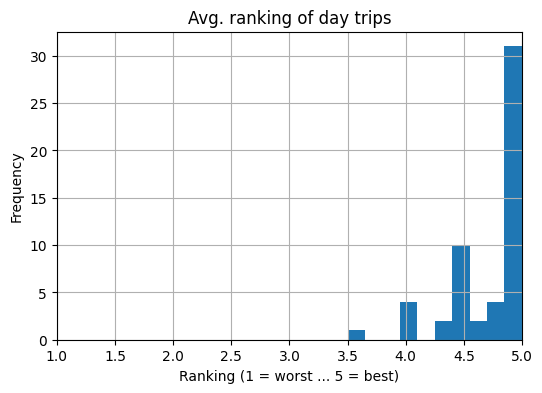

,web-scraper-order,title_raw,price_raw,ranking_raw,duration_raw,text_raw,location,latitude,longitude,price_per_adult,price,max_duration,ranking
0,1713267369-1,31. Titlis-Tagesausflug mit privatem Reiseleit...,CHF 496,5.0 von fünf Punkten1,6 - 8 Stunden,31. Titlis-Tagesausflug mit privatem Reiseleit...,Luzern,47.052547,8.282178,1,496,8,5.0
1,1713267369-2,32. Alpine Majestät: Exklusive Privattour von ...,CHF 699,NaN,Mehr als 6 Stunden,32. Alpine Majestät: Exklusive Privattour von ...,Jungfraujoch,46.546886,7.983592,1,699,6,NaN
2,1713267369-4,34. Vierwaldstättersee Pick and Mix Tour - Bur...,CHF 689,5.0 von fünf Punkten34,8 - 9 Stunden,34. Vierwaldstättersee Pick and Mix Tour - Bur...,Luzern,47.052547,8.282178,1,689,9,5.0
3,1713267369-5,35. Atemberaubende private Wanderung mit einem...,CHF 899,5.0 von fünf Punkten26,8 - 9 Stunden,35. Atemberaubende private Wanderung mit einem...,NaN,NaN,NaN,1,899,9,5.0
4,1713267369-6,36. Best of Bernese Oberland Tour ab Interlaken,CHF 721,5.0 von fünf Punkten12,Mehr als 6 Stunden,36. Best of Bernese Oberland Tour ab Interlake...,Interlaken,46.678734,7.870780,1,721,6,5.0


In [12]:
# Extract numbers from the string
merged_df['ranking'] = merged_df['ranking_raw'].str.strip()
merged_df['ranking'] = merged_df['ranking'].str[:3].astype(float)

# Pivot table to get the average ranking for each trip
pivot_table = merged_df.pivot_table(index='location', 
                                    values='ranking', 
                                    aggfunc='mean').reset_index()

pivot_table.sort_values(by='ranking', ascending=False)

# Histogram with avg. ranking of trips
plt.figure(figsize=(6, 4))
plt.hist(pivot_table['ranking'])
plt.title('Avg. ranking of day trips')
plt.xlabel('Ranking (1 = worst ... 5 = best)')
plt.ylabel('Frequency')
plt.xlim(1, 5)
plt.grid()
plt.show()

merged_df.head()


## Plot locations on map

In [15]:
# Initialisierung der Map
m = folium.Map(location=[47.44, 8.65], zoom_start=8)

# Add lat/lon of addresses
df_sub = merged_df.dropna().drop_duplicates().reset_index(drop=True)

for i in range(0, len(df_sub)):
    popup_text = (
        f"Location: {df_sub.iloc[i]['location']}, "
        f"Ranking: {df_sub.iloc[i]['ranking']}, "
        f"Price per adult: {df_sub.iloc[i]['price']}, "
        f"Duration in hours: {df_sub.iloc[i]['max_duration']}"
    )
    popup = folium.Popup(popup_text, max_width=500)
    folium.Marker(location=(df_sub.iloc[i]['latitude'], df_sub.iloc[i]['longitude']), popup=popup).add_to(m)
    
# Layer control
folium.LayerControl().add_to(m)

# Plot map
m

### Jupyter notebook --footer info-- (please always provide this at the end of each notebook)

In [14]:
import os
import platform
import socket
from platform import python_version
from datetime import datetime

print('-----------------------------------')
print(os.name.upper())
print(platform.system(), '|', platform.release())
print('Datetime:', datetime.now().strftime("%Y-%m-%d %H:%M:%S"))
print('Python Version:', python_version())
print('-----------------------------------')

-----------------------------------
POSIX
Linux | 6.8.0-1030-azure
Datetime: 2025-09-29 08:15:13
Python Version: 3.11.13
-----------------------------------
